# Goals

Dense Neural Networks are an essential building block used in Deep Learning for image analysis. Our goals here are:
* Learn how to use a Neural Network in Classification
* Use a Neural Network to predict good wine

# Install some packages for plotting and evaluation
This will re-start your kernel if the packages can't be loaded

In [1]:
import os
!pip install seaborn
!pip install torchmetrics
!pip install matplotlib

try:
    import matplotlib.pyplot as plt
    import seaborn as sns
    from torchmetrics.classification import Accuracy, F1Score
except:
    os._exit(00)



Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# Classification

Classification is a problem where each of our examples (x) belongs to a class (y). Since Neural networks are universal function approximators, we can use

$P(y|x)$



## Binary Classification
When we just have 2 classes (A or B/True or False) then we only need to predict the probability of one since

$P(y=b|x)$=1-$P(y=a|x)$

Our network inputs are our features, and our network output is $P(y=a|x)$.

**Important:** We need to use the correct activation function and the correct loss function. We know $y_{pred}$
is between zero and one, so we can add a 'sigmoid' activation


$\sigma(x)=\frac{1}{1+e^{-x}}$

<img src='https://raw.githubusercontent.com/jsearcy1/DNNWS_2022/refs/heads/develop/assets/sigmoid.png'>

For the loss function we use something called binary cross-entropy, which uses our labels (0 or 1) to train our network.

$L=\frac{1}{N}*\sum_i(-y_{true,i}*ln(y_{pred,i})-(1-y_{true,i})*ln(1-y_{pred,i}))$

Since our labels are only 0 or 1 this loss will
* Make $-1*ln(y_{pred})$ as small as possible ($y_{pred}=1$) when $y_{true}=1$
* Make $-1*ln(1-y_{pred})$ as small as possible ($y_{pred}=0$) when $y_{true}=0$




## If you're curious

This is essentially the negative log likelihood of a Bernoulli distribution

$P(y,p)=p^{y}(1-p)^{1-y}$

$-ln(P(y,p))=-ln(p^{y}(1-p)^{1-y})= -y*ln(p)-(1-y)*ln(1-p)$

# What it Means for our Neural Network

* When we build our model we need to use a sigmoid activation on the last layer, this often happens in the **forward** function


    x=torch.nn.functional.sigmoid(x)
    output=tf.keras.layers.Dense(1,activation='sigmoid')

    and we will use the following loss

    loss_fn= torch.nn.BCELoss()



## Define some tools to train and plot
1. don't worry about going through this now, we'll go through the steps later

In [3]:
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader, TensorDataset, Subset



def evaluate(model,data_loader):
    with torch.no_grad():
        prediction=[]
        target=[]
        input_1d=[]
        for x_batch,y_batch in data_loader:
            prediction.append(model(x_batch))
            target.append(y_batch)
            input_1d.append(x_batch[:,0:1])
        #combine
        y_pred=torch.cat(prediction,dim=0)
        y_true=torch.cat(target,dim=0)
        x_in=torch.cat(input_1d,dim=0)
    return y_pred,y_true,x_in

def fit_np_ds(model,x,y,n_epochs=10,lr=1e-2):
    # Split Dataset
    dataset=TensorDataset(torch.Tensor(x).float(),torch.Tensor(y).float())
    train_size = int(0.6 * len(dataset))
    val_size = int(0.2 * len(dataset))
    test_size = len(dataset) - train_size - val_size

    train_dataset, val_dataset,test_dataset = random_split(dataset, [train_size, val_size,test_size])

    # Make Data Loaders

    batch_size = 64
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Make optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    if len(y.shape)==1 or y.shape[1]==1:
      loss_fn= torch.nn.BCELoss() # This is usefult, but you use your own equations too!
    else:
      loss_fn= torch.nn.CrossEntropyLoss()
    #Fit

    loss_vals=[]
    val_loss_values=[]
    train_loss_values=[]

    for _epoch in tqdm(range(n_epochs)):
        model.train()
        for x_batch,y_batch in train_loader:
          optimizer.zero_grad()
          y_pred = model(x_batch).squeeze()

          loss = loss_fn(y_pred,y_batch)
          loss.backward()
          loss_vals.append(loss.item())
          optimizer.step()

    # Eval
        model.eval()
        y_pred,y_true,x_in=evaluate(model,val_loader)

        val_loss_values.append(loss_fn(y_pred.squeeze(),y_true))
        train_loss_values.append(np.mean(loss_vals[-10:]))

    y_pred,y_true,x_in=evaluate(model,val_loader)
    ytr_pred,ytr_true,xtr_in=evaluate(model,train_loader)

    return {'val_loss':val_loss_values,'loss':train_loss_values,'y_pred':y_pred,'y_true':y_true}

#    plt.plot(val_loss_values,label='Val. Loss')
#    plt.plot(train_loss_values,label='Train Loss')
#    plt.yscale('log')
#    plt.legend()
#    plt.show()



In [4]:
#Make a test datasets with 2 class labels

#Class A
n_data=10000

x=np.random.normal(1,1,size=n_data)
y=np.ones(n_data) #Class A =1

#Class B
x=np.append(x,np.random.normal(-1,1,size=n_data))
y=np.append(y,np.zeros(n_data)) #Class B=0








# A simple way to look at a feature is a histogram
Plot how many times does class A have a feature value within a bin


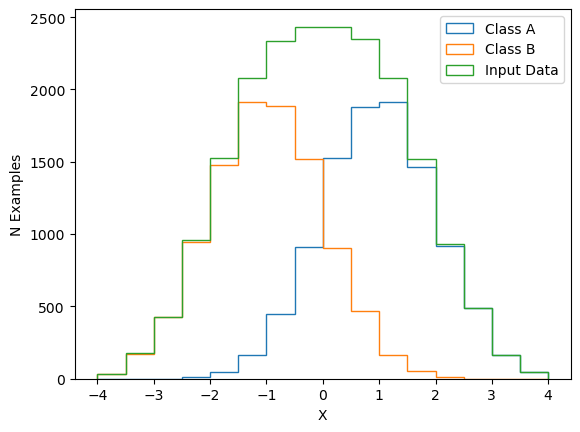

In [5]:
#Histogram for class A
a_mask=y==1
plt.hist(x[a_mask],bins=16,range=(-4,4),histtype='step',label='Class A')

#Histogram for Class B
b_mask=y==0
plt.hist(x[b_mask],bins=16,range=(-4,4),histtype='step',label='Class B')

plt.hist(x,bins=16,range=(-4,4),histtype='step',label='Input Data')

plt.xlabel('X')
plt.ylabel('N Examples')
plt.legend()
plt.show()

In [6]:

class BinaryClassifier(torch.nn.Module):

    def __init__(self,input_size=1):
        super(BinaryClassifier, self).__init__()
        self.input_layer = torch.nn.Linear(input_size, 20)
        self.dense_1 = torch.nn.Linear(20, 20)
        self.output = torch.nn.Linear(20, 1)

        self.act=torch.nn.LeakyReLU()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.act(x)
        x = self.dense_1(x)
        x = self.act(x)
        x = self.output(x)
        x=torch.nn.functional.sigmoid(x) #Sigmoid activation
        return x

nn_model=BinaryClassifier()
out=fit_np_ds(nn_model,x[:,None],y[:],n_epochs=20)


100%|██████████| 20/20 [00:03<00:00,  6.13it/s]


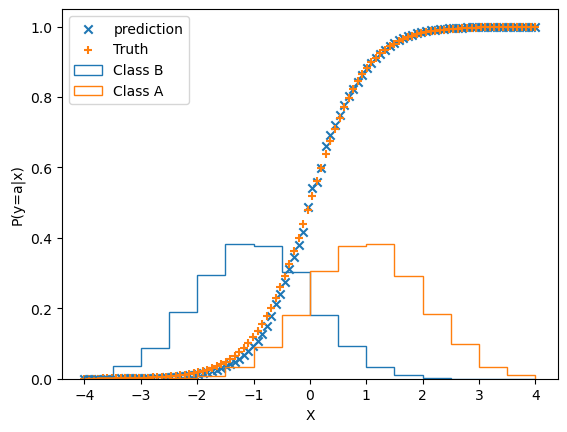

In [7]:

X_test=np.linspace(-4,4,100)
Y_true=1/(1+np.exp(-2*X_test))#Proof Left to Reader

Y_pred=nn_model(torch.Tensor(X_test[:,None]).float()).detach().numpy()
plt.scatter(X_test,Y_pred,label='prediction',marker='x')
plt.scatter(X_test,Y_true,label='Truth',marker='+')

plt.xlabel('X')
plt.ylabel('P(y=a|x)')

plt.hist(x[b_mask],bins=16,range=(-4,4),histtype='step',label='Class B',density=True)
plt.hist(x[a_mask],bins=16,range=(-4,4),histtype='step',label='Class A',density=True)

plt.legend()
plt.show()

# Classification - Multi-Class






In [8]:
#Class A
n_data=10000

y=np.ones(n_data) #Class A =1
x=np.random.normal(1,1,size=(n_data,1))

#Class B
y=np.append(y,np.zeros(n_data)) #Class B=0
x=np.append(x,np.random.normal(-1,1,size=(n_data,1)))

#Class B
y=np.append(y,np.ones(n_data)*2) #Class B=0
x=np.append(x,np.random.normal(-3,1,size=(n_data,1)))




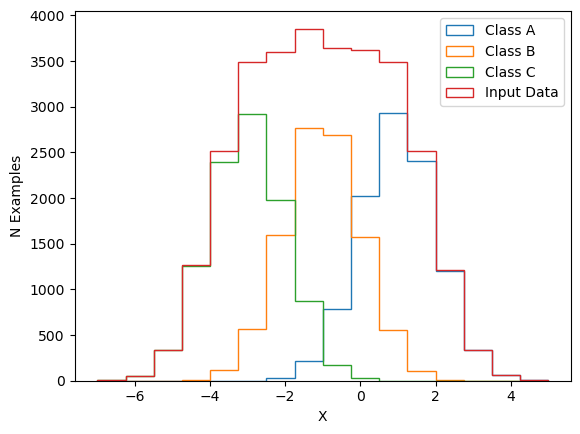

In [9]:
#Histogram for class A
a_mask=y==1
plt.hist(x.squeeze()[a_mask],bins=16,range=(-7,5),histtype='step',label='Class A')

#Histogram for Class B
b_mask=y==0
plt.hist(x.squeeze()[b_mask],bins=16,range=(-7,5),histtype='step',label='Class B')

#Histogram for Class C
c_mask=y==2
plt.hist(x.squeeze()[c_mask],bins=16,range=(-7,5),histtype='step',label='Class C')

plt.hist(x.squeeze(),bins=16,range=(-7,5),histtype='step',label='Input Data')

plt.xlabel('X')
plt.ylabel('N Examples')
plt.legend()
plt.show()





# Multi Class Loss

# Multi-Class Classification

**Reminder**
   * Classification is problem where each of our examples (x) belongs to a class (y). Since Neural networks are universal function approximators, we can use $P(y|x)$

**Like before to change our problem we need**
* The correct activation on our last layer - **softmax**
* The correct loss function - **categorical_crossentropy**

We have more than two classes (0,1,2...) and we need to predict the probability of all of them. However, we have a constraint that all the probabilities must sum to one.

**Our network**
 * Inputs are our images
 * Output is a Dense layer with dimension equal to the number of classes
     * Each output represents $\{P(y=0|x),(y=1|x),(y=2|x)\ ...\}$.
 * We require $\sum_i P(y=i|x) = 1$.

* To enforce this we use a different activation function: a **softmax**

    * $\sigma(x)_i= \frac{e^{x_i}}{\sum_i e^{x_i}}$
    
* Our loss function becomes

 $L=-\frac{1}{N}\sum_i \sum_n y_{true,i,n}*ln(y_{pred,i,n})$

* What this means
    * $y_{true,i,n}$ is a vector with a 1 in the dimention that example belongs to and a zero everywhere else
        *  i.e. class 9/9 = (0,0,0,0,0,0,0,0,0,1)
    * The sum in this loss term  $\sum_n y_{true,i,n}*ln(y_{pred,i,n})$
        * is zero except for the one value when n=class of $y_{true}$
        * Then it's just $ln(y_{pred,i,n})$
        * This is same as binary classfication: make -1*$ln(y_{pred,i,n})$ as small as possible



Our input data set has labels stored as integers, but the labels we need for our loss function need to be  **one-hot** encoded

**one-hot** - A vector of zeros except for one entry with a 1 that represents the class of an object
   * i.e. class 2 = (0,0,1)

torch has a utility to convert integers like this easily.

In [10]:
y_one_hot = torch.nn.functional.one_hot(torch.Tensor(y).long(), num_classes=3)


### You can do the inverse with argmax
some functions want classes as interegers, and some one them as one-hot vectors, so it's helpful to be able to go back and forward.

In [11]:
print(y_one_hot[0])
print( torch.argmax(y_one_hot,dim=1)[0])
print(y[0])

tensor([0, 1, 0])
tensor(1)
1.0


# Multi-class Classifier Model
* Remember the output size changes
* Output activation changess

In [12]:

class MultiClassifier(torch.nn.Module):

    def __init__(self,):
        super(MultiClassifier, self).__init__()
        self.input_layer = torch.nn.Linear(1, 20)
        self.dense_1 = torch.nn.Linear(20, 20)
        self.dense_2 = torch.nn.Linear(20, 20)
        self.output = torch.nn.Linear(20, 3)
        self.act=torch.nn.LeakyReLU()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.act(x)
        x = self.dense_1(x)
        x = self.act(x)
        x = self.dense_2(x)
        x = self. act(x)
        x = self.output(x)
        x=torch.nn.functional.softmax(x,dim=-1) #Sigmoid activation
        return x

multi_model=MultiClassifier()
out=fit_np_ds(multi_model,x[:,None],y_one_hot[:])

100%|██████████| 10/10 [00:02<00:00,  3.60it/s]


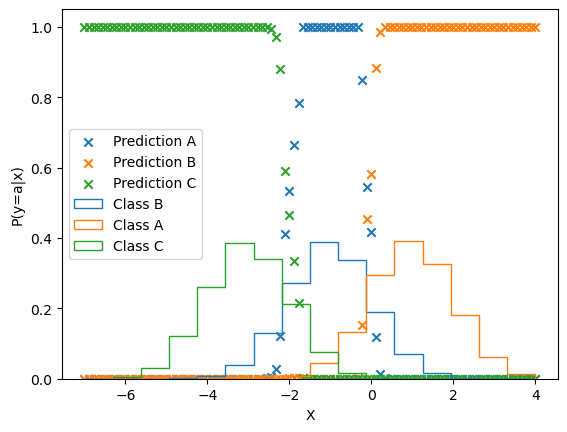

In [13]:
X_test=np.linspace(-7,4,100)[:,None]
#Y_true=1/(1+np.exp(-2*X_test))#Proof Left to Reader

Y_pred=multi_model(torch.Tensor(X_test)).detach().numpy()


plt.scatter(X_test,Y_pred[:,0],label='Prediction A',marker='x')
plt.scatter(X_test,Y_pred[:,1],label='Prediction B',marker='x')
plt.scatter(X_test,Y_pred[:,2],label='Prediction C',marker='x')


plt.xlabel('X')
plt.ylabel('P(y=a|x)')

plt.hist(x[b_mask],bins=16,range=(-7,4),histtype='step',label='Class B',density=True)
plt.hist(x[a_mask],bins=16,range=(-7,4),histtype='step',label='Class A',density=True)
plt.hist(x[c_mask],bins=16,range=(-7,4),histtype='step',label='Class C',density=True)

plt.legend()
plt.show()

# Dense/Linear network summary

* Dense networks take fixed length input and have a fixed length output
* Like All Neural Network layers they require an activation function
    * The activation of the last layer is usally determined by the goal
        * Regression - Linear
        * Classification - Sigmoid
        * Multi-Class Classification - Softmax (more later)
* They can be stacked to represent more complicated functions
* You're taking your chances when predicting data that's very different from you're training data


# A Real World Example
We're going to use a number of measured values to try and predict good wine.
Source:https://archive.ics.uci.edu/ml/datasets/Wine+Quality (Cortez et al., 2009)

* Goal: Predict whether a wine is excellent based score given to the wine by an expert panel (1-10)
    * Score > 5 Excellent
    * Score <=5 Average

* Features:
  * 1 - fixed acidity
  * 2 - volatile acidity
  * 3 - citric acid
  * 4 - residual sugar
  * 5 - chlorides
  * 6 - free sulfur dioxide
  * 7 - total sulfur dioxide
  * 8 - density
  * 9 - pH
  * 10 - sulphates
  * 11 - alcohol
  * 12 - Red/White




# Step 1: Look at the data

In [14]:
import os
if not os.path.exists('winequality.names'):
  os.system("wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality.names")
  os.system('wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv')
  os.system('wget https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv')

In [15]:
!cat winequality.names

Citation Request:
  This dataset is public available for research. The details are described in [Cortez et al., 2009]. 
  Please include this citation if you plan to use this database:

  P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
  Modeling wine preferences by data mining from physicochemical properties.
  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 0167-9236.

  Available at: [@Elsevier] http://dx.doi.org/10.1016/j.dss.2009.05.016
                [Pre-press (pdf)] http://www3.dsi.uminho.pt/pcortez/winequality09.pdf
                [bib] http://www3.dsi.uminho.pt/pcortez/dss09.bib

1. Title: Wine Quality 

2. Sources
   Created by: Paulo Cortez (Univ. Minho), Antonio Cerdeira, Fernando Almeida, Telmo Matos and Jose Reis (CVRVV) @ 2009
   
3. Past Usage:

  P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. 
  Modeling wine preferences by data mining from physicochemical properties.
  In Decision Support Systems, Elsevier, 47(4):547-553. ISSN: 016

# Combine into a dataframe

In [16]:
import pandas as pd
reds=pd.read_csv('winequality-red.csv',skiprows=0,delimiter=';' )
reds['type']= 1. #'red'
whites=pd.read_csv('winequality-white.csv',skiprows=0,delimiter=';')
whites['type']= 0. #'white'
data=pd.concat([reds,whites],axis=0).reset_index()


In [17]:
data.head()

,index,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,type
0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1.0
1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1.0
2,2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,1.0
3,3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1.0
4,4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,1.0


<Axes: >

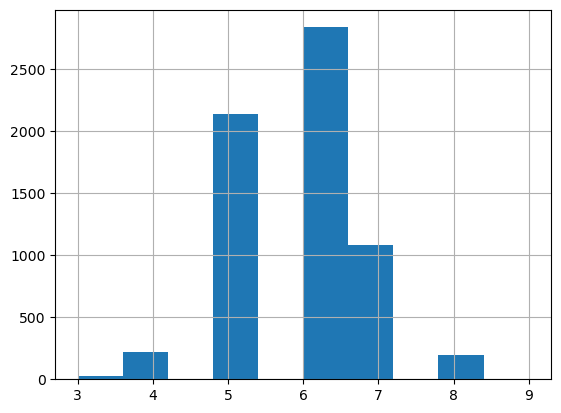

In [18]:
data['quality'].hist()

# Binary Classification
Let's start by setting this problem up as a binary classification problem.
Split the 'good' wine from the 'bad' wine down the middle.

In [19]:
predictors=['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol','type']


#Predict 'Top'

x=data[predictors].values
y=(data['quality'] > 5).values

#for p in predictors:
#   sns.histplot(data,x=p,hue=y,common_norm=False,stat='density',bins=20)
#   plt.show()


In [20]:
display(data[predictors])

print(x.shape,y.shape)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,type
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,1.0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.99680,3.20,0.68,9.8,1.0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.99700,3.26,0.65,9.8,1.0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.99800,3.16,0.58,9.8,1.0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.99780,3.51,0.56,9.4,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6492,6.2,0.21,0.29,1.6,0.039,24.0,92.0,0.99114,3.27,0.50,11.2,0.0
6493,6.6,0.32,0.36,8.0,0.047,57.0,168.0,0.99490,3.15,0.46,9.6,0.0
6494,6.5,0.24,0.19,1.2,0.041,30.0,111.0,0.99254,2.99,0.46,9.4,0.0
6495,5.5,0.29,0.30,1.1,0.022,20.0,110.0,0.98869,3.34,0.38,12.8,0.0


(6497, 12) (6497,)


In [21]:
import random
random.seed(100)
split_index=list(range(len(data)))
random.shuffle(split_index)

train_size = int(0.6 * len(data))
val_size = int(0.2 * len(data))
test_size = len(data) - train_size - val_size
print(len(data),np.max(len(split_index[train_size:train_size+val_size])))

data['dset']='train'
data.loc[split_index[train_size:train_size+val_size],'dset']='val'
data.loc[split_index[train_size+val_size:],'dset']='test'

data['target']=data['quality'] >5

x=data[predictors].values
y=data['target'].values

train_x=x[data['dset']=='train' ]
val_x=x[data['dset']=='val' ]
test_x=x[data['dset']=='test' ]

train_y=y[data['dset']=='train' ]
val_y=y[data['dset']=='val' ]
test_y=y[data['dset']=='test' ]


#train_dataset=TensorDataset(torch.Tensor(x).float(),torch.Tensor(y).float())

6497 1299


<Axes: xlabel='alcohol', ylabel='Count'>

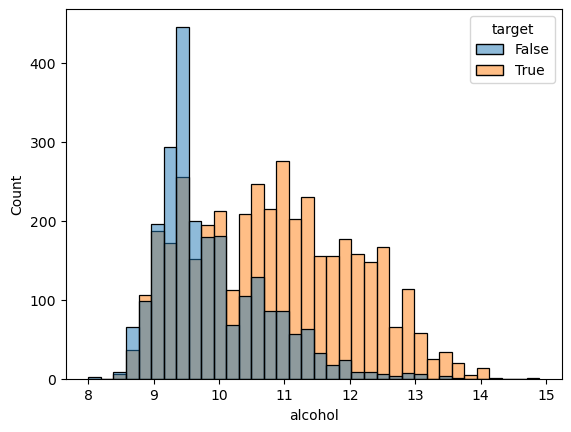

In [22]:
sns.histplot(data,x='alcohol',hue='target')


# Normalize Data

Remember to normalize your data

## An important point
Always use your **training** data to calculate the constants you use to normalize your data.
This prevents data-leakage, which is a general term for using information your model won't actually have when it's being used after being trained.



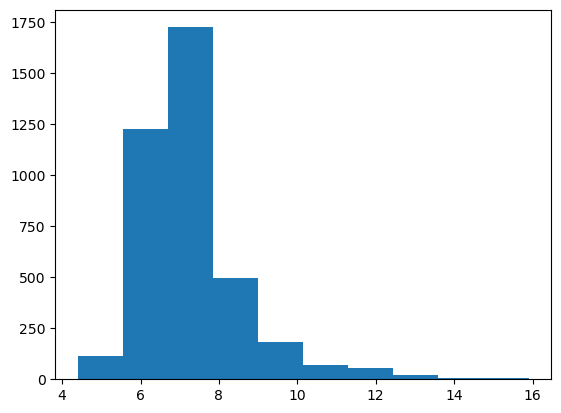

In [23]:
plt.hist(train_x[:,0])
plt.show()

In [24]:
train_x.mean(axis=0)

array([7.24354797e+00, 3.41454592e-01, 3.21890713e-01, 5.47204977e+00,
       5.60715752e-02, 3.04266290e+01, 1.15821447e+02, 9.94718521e-01,
       3.21727296e+00, 5.29928168e-01, 1.04952078e+01, 2.45253976e-01])

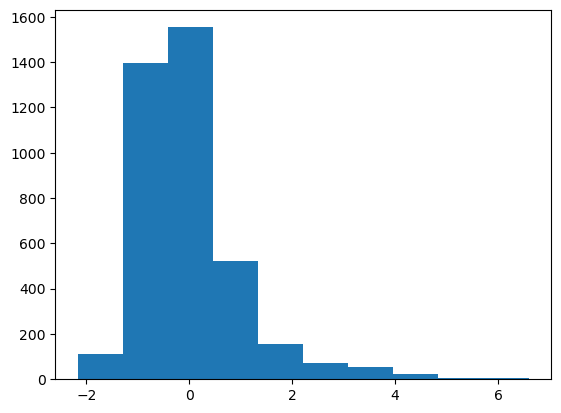

In [25]:
mean=train_x.mean(axis=0)
std=train_x.std(axis=0)


train_x=(train_x-mean)/std
val_x=(val_x-mean)/std
test_x=(test_x-mean)/std
x=(x-mean)/std

plt.hist(train_x[:,0])
plt.show()

In [26]:
train_dataset=TensorDataset(torch.Tensor(train_x).float(),torch.Tensor(train_y).float())
val_dataset=TensorDataset(torch.Tensor(val_x).float(),torch.Tensor(val_y).float())
test_dataset=TensorDataset(torch.Tensor(test_x).float(),torch.Tensor(test_y).float())

# Build a Model

1. This a model has many mistakes!
2.  Let's fix it together
   

In [27]:
from sklearn.preprocessing import OneHotEncoder

x=data[predictors].values
y=(data['quality']).values
encoder = OneHotEncoder(sparse=False)
y_one_hot = encoder.fit_transform(y.reshape(-1,1))

class WineMultiClassifier(torch.nn.Module):

    def __init__(self,):
        super(WineMultiClassifier, self).__init__()
        self.input_layer = torch.nn.Linear(12, 20)
        self.layer1 = torch.nn.Linear(20, 20)
        self.layer2 = torch.nn.Linear(20, 20)
        self.layer3 = torch.nn.Linear(20, 20)
        
        self.output = torch.nn.Linear(20, 7)
        self.act=torch.nn.LeakyReLU()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.act(x)
        x = self.layer1(x)
        x = self.act(x)
        x = self.layer2(x)
        x = self.act(x)
        x = self.layer3(x)
        x = self.act(x)
        x = torch.nn.functional.softmax(self.output(x))
        return x



/home/msuresh/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [28]:
train_y_one=y_one_hot[data['dset']=='train' ]
val_y_one=y_one_hot[data['dset']=='val' ]
test_y_one=y_one_hot[data['dset']=='test' ]

In [29]:
train_dataset_one=TensorDataset(torch.Tensor(train_x).float(),torch.Tensor(train_y_one).float())
val_dataset_one=TensorDataset(torch.Tensor(val_x).float(),torch.Tensor(val_y_one).float())
test_dataset_one=TensorDataset(torch.Tensor(test_x).float(),torch.Tensor(test_y_one).float())

# Train Model

In [46]:
batch_size = 64
n_epochs=20
lr=1e-3
weight_decay=0

multi_wine_model=WineMultiClassifier()
optimizer = torch.optim.Adam(multi_wine_model.parameters(), lr=lr, weight_decay=weight_decay)
#optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)


In [47]:
y_one_hot.shape

(6497, 7)

In [48]:
accuracy = Accuracy(task="multiclass", num_classes=7)
f1_score = F1Score(task="multiclass", num_classes=7)

train_loader = DataLoader(train_dataset_one, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset_one, batch_size=batch_size, shuffle=False)
loss_fn= torch.nn.CrossEntropyLoss()

accuracy_vals=[]
step_loss_vals=[]
val_loss_values=[]
train_loss_values=[]
for _epoch in tqdm(range(n_epochs)):
    multi_wine_model.train()
    for x_batch,y_batch in train_loader:
        optimizer.zero_grad()
        y_pred_one = multi_wine_model(x_batch).squeeze()
        loss = loss_fn(y_pred_one,y_batch)
        loss.backward()
        step_loss_vals.append(loss.item())
        optimizer.step()
    multi_wine_model.eval()
    y_pred_one,y_true_one,x_in=evaluate(multi_wine_model,val_loader)
    val_loss_values.append(loss_fn(y_pred_one.squeeze(),y_true_one))
    train_loss_values.append(np.mean(step_loss_vals[-10:]))
    accuracy_vals.append(accuracy(y_pred_one.squeeze(),y_true_one))


#data['pred']=multi_wine_model(torch.Tensor(x).float()).detach().numpy()

preds = torch.argmax(multi_wine_model(torch.Tensor(x).float()), dim=1).detach().numpy()
data['pred'] = preds

  0%|          | 0/20 [00:00<?, ?it/s]/tmp/ipykernel_3686417/1078254701.py:29: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  x = torch.nn.functional.softmax(self.output(x))
100%|██████████| 20/20 [00:01<00:00, 14.21it/s]


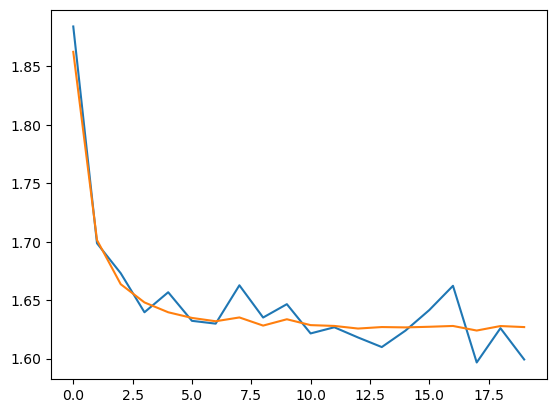

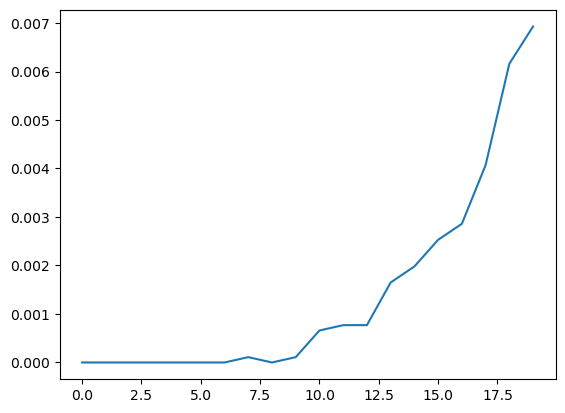

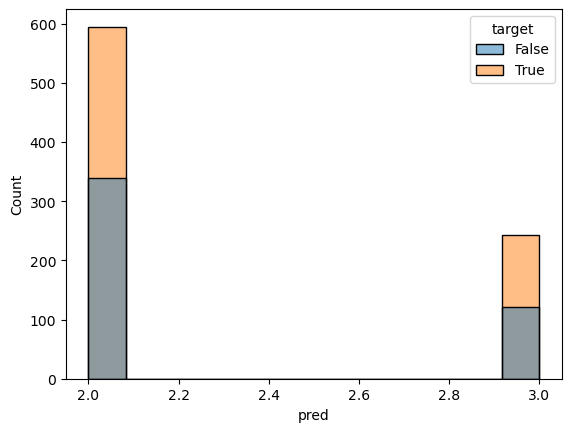

F1 Score tensor(0.0069)
Accuracy tensor(0.0069)


In [49]:
from torchmetrics import Accuracy,F1Score
plt.plot(train_loss_values,label='Train Loss')
plt.plot(val_loss_values,label='Val Loss')
plt.show()

plt.plot(accuracy_vals,label='Val Loss')
plt.show()


sns.histplot(data[data['dset']=='val'],x='pred',hue='target')
plt.show()

#sns.histplot(data,x='pred',hue='dset',common_norm=False,stat='density')
#plt.show()

#sns.histplot(data,x= np.log(1/data['pred']-1),hue='dset',common_norm=False,bins=50,stat='density')
#plt.yscale('log')
#plt.show()

accuracy = Accuracy(task="multiclass", num_classes=7)
f1_score = F1Score(task="multiclass", num_classes=7)

print('F1 Score',f1_score(y_pred_one.squeeze(),y_true_one))
print('Accuracy',accuracy(y_pred_one.squeeze(),y_true_one))


The Test loss should only slightly differ from the develop loss, if that's true you have a well trained network ready to evaluate new wine.


# Try it yourself can you train a better neural network?


* Start with the network above
* Try adding layers, or hidden units
* Try training with Weight Decay
* Watch the val_loss when training make sure it doesn't start going up
* if it does stop the training
* **Don't use test data yet!** we'll see who has the best accuracy on the test data at the end of the class

# Remember
* More layers and neurons give you better flexibility, but take longer to train and you need to worry more about overfitting
* Your input layer needs to be the same size as the number of features you'll use
* Your out layer needs to have the same size and activation function to match the problem
* Play with whatever you might now

In [165]:
"Wite your best parameters here"

best_accuracy=0.7906
best_f1=0.8460
"""
paste your model with the best accuracy 
"""

"""
paste your models learning, rate, epochs, weight decay and batch_size 
"""
batch_size = 64
n_epochs=20
lr=1e-3
weight_decay=0

# Are we happy with the model's preformance on the validation set?
* Yes let's confirm with the test set
    






In [166]:
#We can use the evaluate function to caculate the loss and accuracy of different datasets
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
y_pred,y_true,x_in=evaluate(wine_model,test_loader)
test_loss=loss_fn(y_pred.squeeze(),y_true)

print('F1 Score',f1_score(y_pred.squeeze(),y_true))
print('Accuracy',accuracy(y_pred.squeeze(),y_true))


F1 Score tensor(0.8267)
Accuracy tensor(0.7723)


# Multi-class Classification
I would like you create and train your own model
1. Start with your best model above
2. Modify it as little as possible for a multi-class classification problem
3. Try to predict Quality teaching each value as an independent class

## Checklist
did you
1. Create a new nn.Module class
2. Change the number of output neurons
3. Change the activation function of the output
4. Create a new set of 1-hot data
5. re-create your datasets
6. re-create your dataloaders



## **I accidentally reworked the binary model above to be the multi-class model! I have included the best F1 and accuracy scores from my binary class in the cell above, but then changed the model to a multi-class one instead. Sorry!**

# 510 - Regression

1. Try one more more model with treating quality as a regression problem, write a model and train it.


In [ ]:
"Model Code here"

# 510 - Compare

I would like to detect wine with a quality greater than 5 as we did above, compare the accuracy of each different model above? You'll need to
1. Convert each predictions into a binary one and 


In [ ]:
"Comparision code"


2. What do you see, are there any advantage or disadvantages for each of these methods.

In [ ]:
"Answer"



3. Would your answer be different if we were detecting wines with quality > 6

In [ ]:
"Answer"